<a href="https://colab.research.google.com/github/neeraj310/Semster_1_NLP/blob/master/nlp_ex03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import keras
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Input, Embedding, Reshape
from tensorflow.keras.layers import MaxPooling1D,Flatten, Dropout, Dense, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import time
import itertools

max_features = 6000
maxlen = 268
batch_size = 100
embedding_dims = 50
filters = 400
kernel_size = 5
hidden_dims = 250
epochs = 5


In [0]:
class DATA_PREPROCESSOR():
    def __init__(self, file_name1,file_name2,file_name3):
        
        my_absolute_dirpath = os.path.abspath(os.path.dirname(file_name1))
        self.file_name1 = os.path.join(my_absolute_dirpath + '/' + file_name1) 
        print(self.file_name1)    
               
        self.file_name2 = os.path.join(my_absolute_dirpath + '/' +file_name2) 
        print(self.file_name2) 
       
        self.file_name3 = os.path.join(my_absolute_dirpath + '/' +file_name3) 
        print( self.file_name3) 
   

    def readDataSet(self):
        '''
        Read input corpus file 
        '''
        filename = self.file_name1
        print(filename)    
       
        tweets = []
        for line in open(filename, 'r',encoding='utf-8-sig'):
             tweets.append(json.loads(line))
             
        tweets_df = pd.DataFrame(tweets, columns=['tweetIDs','text'])
             
        filename = self.file_name2
        
        train_labels = pd.read_csv(filename, sep = '\t', header=None,names = ['label','tweetIDs'])
        
        filename = self.file_name3
        test_labels =  pd.read_csv(filename, sep = '\t', header=None,names = ['label','tweetIDs'])
        
        return(tweets_df,train_labels, test_labels)
                
    def merge_tweets_and_labels(self,tweets, labels):
        # merge tweets_id and train/test labels data set to get the training and test data
        merged_df = pd.merge(left = tweets, right=labels,left_on ='tweetIDs',right_on='tweetIDs', how='inner')
        return merged_df    
    
    def handle_class_imblance(self,train):
        # Replace labels of all samples in training set with frequency less than 200  
        imbalanced_languages = train.groupby("label").filter(lambda x: len(x) <= 200)
        imbalanced_labels = train.label.isin(imbalanced_languages.label)
        # replace imblance labels with und(undefined)
        train.loc[imbalanced_labels, 'label'] = 'und'
        return train       
    
    def data_cleaning(self,train,test):
        
        ### Data Cleaning
        train.drop('tweetIDs', axis = 1, inplace=True)
        test.drop('tweetIDs', axis = 1, inplace=True)
        # Remove white spaces from the labels
        train.label = train.label.str.strip()
        test.label = test.label.str.strip()
                    
        train = self.handle_class_imblance(train)
        ###Training Set split into Trainng and Validation Set
        train, validation = train_test_split(train, test_size=0.1, random_state=42)
       
        print(train.groupby('label').label.size())
        #validation = train.copy()
       
        # train=train.groupby("label").filter(lambda x: len(x) >= 10)
        # Remove labels from Validation and Test Set which are not present in Training Set
        validation = (validation[validation.label.isin(train.label)])
        test = (test[test.label.isin(train.label)])
        return train, validation, test

   
    def preprocess_data(self):
        '''
        Preprocess the input corpus. Following steps are involed in data cleaning
        
        '''
        tweets_df,train_labels, test_labels = self.readDataSet()
         # adjust data type of tweetIDs to match the labels
        tweets_df['tweetIDs']=tweets_df['tweetIDs'].astype('int64')
        # merge tweets and labels to get the training df
        train = self.merge_tweets_and_labels(tweets_df, train_labels)
        test = self.merge_tweets_and_labels(tweets_df, test_labels)
        train, validation, test = self.data_cleaning(train, test)
        
        return train, validation, test

In [0]:
def probabilty_to_classencoding(y_pred):
    y_class = np.array( y_pred )
    idx = np.argmax(y_class, axis=-1)
    y_class = np.zeros(y_class.shape )
    y_class[ np.arange(y_class.shape[0]), idx] = 1
    return y_class

def binary_class_to_label(binary_class):
    return(np.argmax(binary_class, axis=1))
    

In [0]:
def data_plotting(dataSet, title_str):
    plt.figure(figsize=(20,25))
    dataSet.groupby('label').label.count().plot.bar(ylim=0)
    plt.title(title_str)
    plt.show()
    
def tokenizer(train, test,validation):
    tokenizer = Tokenizer(char_level = True)
    tokenizer.fit_on_texts(train.text)
    x_train = tokenizer.texts_to_sequences(train.text)
    x_test =  tokenizer.texts_to_sequences(test.text)
    x_validation =  tokenizer.texts_to_sequences(validation.text)
       
    x_train = pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post', value=0)
    x_test = pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post', value=0)
    x_validation = pad_sequences(x_validation, maxlen=maxlen, padding='post', truncating='post', value=0)   
    
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(train.label)
    np.unique(y_train)
    num_class = max(y_train+1)
    y_train = to_categorical(y_train,num_class)
    y_test= label_encoder.transform(test.label)
    y_test = to_categorical(y_test,num_class)
    y_validation= label_encoder.transform(validation.label)
    y_validation = to_categorical(y_validation,num_class)
    return (x_train, x_test, x_validation, y_train, y_test,y_validation)

def model_cnn(x_train, y_train, x_val, y_val, params):
    # then we can go ahead and set the parameter space
   
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
    print('a')
    model.add(Conv1D((filters),
                 (kernel_size),
                 padding='valid',
                 activation= params['activation'],
                 strides=(1)))
    print('b')
    # we use max pooling:
    model.add(GlobalMaxPooling1D())
    
    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(params['dropout']))
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(14))
    model.add(Activation('sigmoid'))
    #optimizer = 'adam'
    model.compile(loss='categorical_crossentropy',
              optimizer=params['optimizer'],
              metrics=['accuracy'])
    model.summary()
    print('d')
    
    history = model.fit(x_train, y_train,
                        batch_size=params['batch_size'],
                        validation_data = (x_validation, y_validation),
                        epochs=3,verbose = 1)
    print('e')
    return (history,model)

def model_1(filters, kernel_size, dropout, optimizer):
    # then we can go ahead and set the parameter space
   
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
    print('a')
    model.add(Conv1D((filters),
                 (kernel_size),
                 padding='valid',
                 activation='relu',
                 strides=(1)))
    print('b')
    # we use max pooling:
    model.add(GlobalMaxPooling1D())
    
    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(dropout),)
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(14))
    model.add(Activation('sigmoid'))
    #optimizer = 'adam'
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    model.summary()
    return model
   


def plot_history(history):
    # Plot training & validation accuracy values
    print(history.history)
    training_accuracy = history.history['acc']
    test_accuracy = history.history['val_acc']
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    epoch_count = range(1, len(training_loss) + 1)
    
    plt.figure(figsize=(7,7))
    plt.plot(epoch_count, training_accuracy, 'r--')
    plt.plot(epoch_count, test_accuracy, 'b-')
    plt.legend(['Training accuracy', 'Test accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model accuracy')
    plt.show();
    
    plt.figure(figsize=(7,7))
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss',    'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model loss')
    plt.show();
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def gridsearch_output(validator, data_tuple,train):
    
    print('The parameters of the best model are: ')
    print(validator.best_params_)
    print('Grid Result Best Score is ')
    print(validator.best_score_)
    
    best_model = validator.best_estimator_.model
    x_train,x_validation, x_test, y_train,y_validation, y_test = data_tuple
    print('Accuracy on validation Test')
    loss, accuracy = best_model.evaluate(x_validation, y_validation)
    print('loss = {} : accuraacy : {}'.format(loss, accuracy))

    print('Accuracy on Test Set')
    metric_names = best_model.metrics_names
    metric_values = best_model.evaluate(x_test, y_test)
    for metric, value in zip(metric_names, metric_values):
        print(metric, ': ', value)

    y_true, y_pred = y_test, best_model.predict(x_test)
    # conver predicted prbablity values to one hot encoding
    y_pred = probabilty_to_classencoding(y_pred)

    print('Confusion Matrix')
    cm = confusion_matrix(binary_class_to_label(y_true), binary_class_to_label(y_pred))
    print(cm)

    print(classification_report(binary_class_to_label(y_true), binary_class_to_label(y_pred)))
    plot_confusion_matrix(cm,classes=train.label.unique())
    
    history = best_model.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data = (x_validation, y_validation),
          epochs=5,verbose = 1)
    print(history.history)
    plot_history(history)


def model_2(activation,learn_rate):
    # then we can go ahead and set the parameter space
   
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
    model.add(Conv1D((filters),
                 (kernel_size),
                 padding='valid',
                 activation=activation,
                 strides=(1)))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())
    
    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.5),)
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(14))
    model.add(Activation('sigmoid'))
    #optimizer = 'adam'
    optimizer = SGD(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    model.summary()
    return model

In [0]:
def model_3(strides,kernel_size,optimizer):
    # then we can go ahead and set the parameter space
   
    
    model = Sequential()

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
    model.add(Conv1D((filters),
                 (kernel_size),
                 padding='valid',
                 activation='elu',
                 strides=strides))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())
    
    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.3),)
    model.add(Activation('relu'))
    
    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(14))
    model.add(Activation('sigmoid'))
    #optimizer = 'adam'
    #optimizer = SGD(lr=learn_rate)
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    model.summary()
    return model

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving labels-test.tsv to labels-test.tsv
Saving labels-train+dev.tsv to labels-train+dev.tsv
Saving tweets.json to tweets.json
User uploaded file "labels-test.tsv" with length 532552 bytes
User uploaded file "labels-train+dev.tsv" with length 2129823 bytes
User uploaded file "tweets.json" with length 6925882 bytes


In [8]:
preprocessor = DATA_PREPROCESSOR('tweets.json','labels-train+dev.tsv','labels-test.tsv')
train, validation, test, = preprocessor.preprocess_data()
# plot training and validation data
#data_plotting(train, 'Training Data Set Label Frequency')

x_train, x_test,x_validation, y_train, y_test, y_validation = tokenizer(train, test,validation)

/content/tweets.json
/content/labels-train+dev.tsv
/content/labels-test.tsv
/content/tweets.json
label
ar      2072
en     16889
es      5379
fr       863
id      2714
it       295
ja      9373
ko       412
pt      2598
ru       900
th       412
tl       295
tr       613
und     5307
Name: label, dtype: int64


a
b
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_63 (Embedding)     (None, 268, 50)           300000    
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 266, 100)          15100     
_________________________________________________________________
global_max_pooling1d_63 (Glo (None, 100)               0         
_________________________________________________________________
dense_126 (Dense)            (None, 250)               25250     
_________________________________________________________________
dropout_63 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_126 (Activation)  (None, 250)               0         
_________________________________________________________________
dense_127 (Dense)            (None, 14)          

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


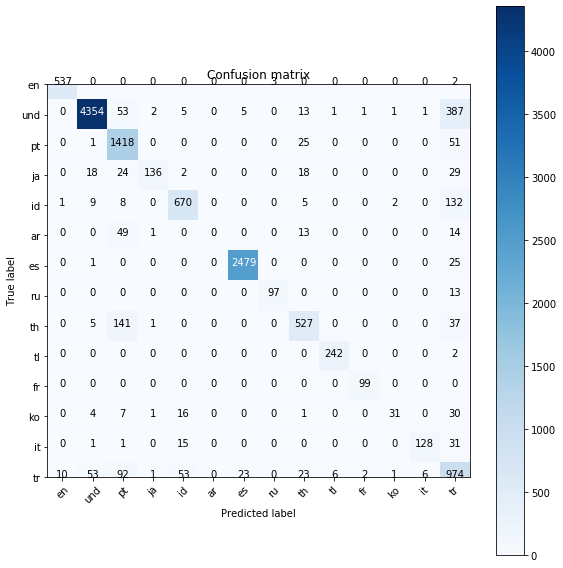

Train on 48122 samples, validate on 5347 samples
Epoch 1/5
48122/48122 [==============================] - 9s 186us/sample - loss: 0.2989 - acc: 0.9021 - val_loss: 0.2529 - val_acc: 0.9123
Epoch 2/5
48122/48122 [==============================] - 9s 181us/sample - loss: 0.2251 - acc: 0.9262 - val_loss: 0.2336 - val_acc: 0.9200
Epoch 3/5
48122/48122 [==============================] - 9s 183us/sample - loss: 0.1821 - acc: 0.9397 - val_loss: 0.2400 - val_acc: 0.9181
Epoch 4/5
48122/48122 [==============================] - 9s 186us/sample - loss: 0.1508 - acc: 0.9497 - val_loss: 0.3130 - val_acc: 0.8968
Epoch 5/5
48122/48122 [==============================] - 9s 181us/sample - loss: 0.1258 - acc: 0.9570 - val_loss: 0.2354 - val_acc: 0.9271
{'loss': [0.2989114082182, 0.22509717007708874, 0.18208015125519983, 0.15084203982997538, 0.125833914036587], 'acc': [0.902103, 0.92616683, 0.9396534, 0.94969034, 0.9570051], 'val_loss': [0.25294465647025577, 0.23358516651201364, 0.24000692948885716, 0.313

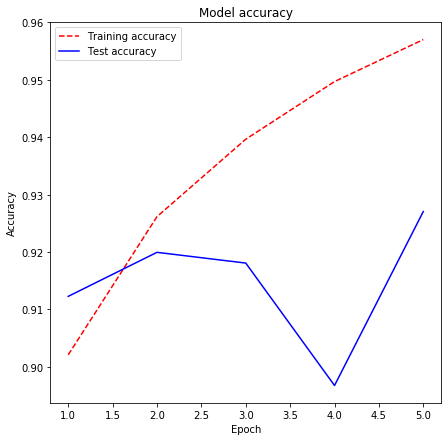

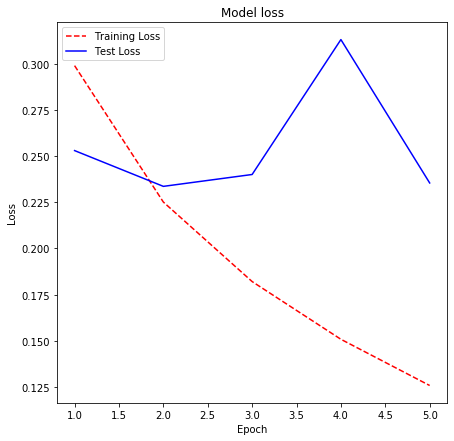

In [0]:
model_01 = KerasClassifier(model_1, batch_size=100, verbose = 0)
validator = GridSearchCV(model_01,
                         param_grid={'filters': [100,200,400],
                                     'kernel_size': [3,5,10],
                                     'dropout':[0.3,0.4,0.5],
                                     'optimizer': ['Adam', 'Nadam']},
                         verbose = 0,                                   
                         cv= 5)
validator.fit(x_train, y_train, verbose = 0)

data_tuple = ( x_train,x_validation, x_test, y_train,y_validation, y_test)
gridsearch_output(validator,data_tuple,train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Model: "sequential_340"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_339 (Embedding)    (None, 268, 50)           300000    
_________________________________________________________________
conv1d_339 (Conv1D)          (None, 266, 250)          37750     
_________________________________________________________________
global_max_pooling1d_339 (Gl (None, 250)               0         
_________________________________________________________________
dense_678 (Dense)            (None, 250)               62750     
_________________________________________________________________
dropout_339 (Dropout)        (None, 250)               0         
_________________________________________________________________
activation_678 (Activation)  (None, 250)               0         
_________________________________________________________

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential_341"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_340 (Embedding)    (None, 268, 50)           300000    
_________________________________________________________________
conv1d_340 (Conv1D)          (None, 266, 250)          37750     
_________________________________________________________________
global_max_pooling1d_340 (Gl (None, 250)               0         
_________________________________________________________________
dense_680 (Dense)            (None, 250)               62750     
_________________________________________________________________
dropout_340 (Dropout)        (None, 250)               0         
_________________________________________________________________
activation_680 (Activation)  (None, 250)               0         
_________________________________________________________________
dense_681 (Dense)            (None, 14)             

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 109.9min finished


Model: "sequential_430"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_429 (Embedding)    (None, 268, 50)           300000    
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 266, 250)          37750     
_________________________________________________________________
global_max_pooling1d_429 (Gl (None, 250)               0         
_________________________________________________________________
dense_858 (Dense)            (None, 250)               62750     
_________________________________________________________________
dropout_429 (Dropout)        (None, 250)               0         
_________________________________________________________________
activation_858 (Activation)  (None, 250)               0         
_________________________________________________________________
dense_859 (Dense)            (None, 14)             

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


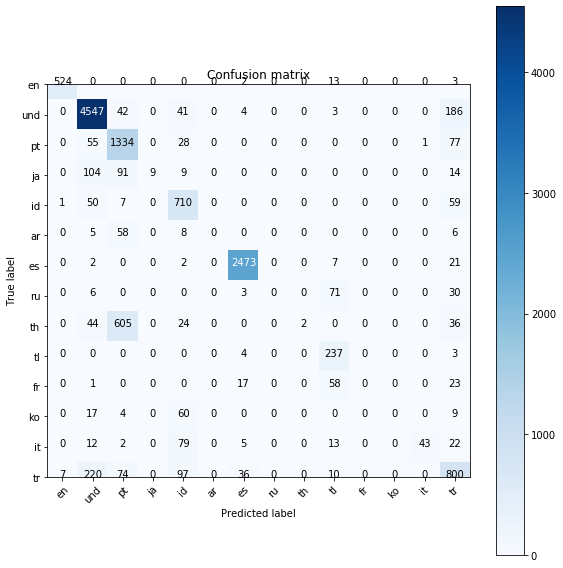

Train on 48122 samples, validate on 5347 samples
Epoch 1/5
48122/48122 [==============================] - 8s 167us/sample - loss: 0.5848 - acc: 0.8054 - val_loss: 0.5147 - val_acc: 0.8300
Epoch 2/5
48122/48122 [==============================] - 8s 167us/sample - loss: 0.5013 - acc: 0.8393 - val_loss: 0.4630 - val_acc: 0.8457
Epoch 3/5
48122/48122 [==============================] - 8s 174us/sample - loss: 0.4440 - acc: 0.8579 - val_loss: 0.4086 - val_acc: 0.8650
Epoch 4/5
48122/48122 [==============================] - 8s 168us/sample - loss: 0.4012 - acc: 0.8718 - val_loss: 0.3781 - val_acc: 0.8734
Epoch 5/5
48122/48122 [==============================] - 8s 167us/sample - loss: 0.3748 - acc: 0.8806 - val_loss: 0.4060 - val_acc: 0.8725
{'loss': [0.5847728623252305, 0.5013485878556105, 0.44401407915132557, 0.40123353286711216, 0.37476740609784015], 'acc': [0.8053905, 0.8393251, 0.8578613, 0.87182575, 0.8805536], 'val_loss': [0.5146557841096746, 0.4630043505396111, 0.4085722052428975, 0.37

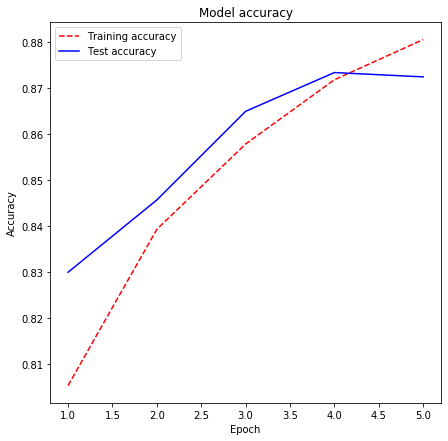

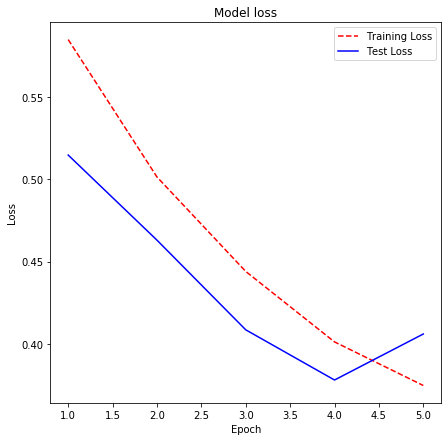

--- time for model 2 is 6751.693562746048 seconds ---


In [0]:
start_time = time.time()
model_02 = KerasClassifier(model_2, verbose = 0)
validator_2 = GridSearchCV(model_02,
                         param_grid={'activation': ['relu','elu'],
                                     'learn_rate' : [0.001,0.01,0.1],
                                     'batch_size' : [25,50,100],
                                     
                                    },
                         verbose = 1,                                   
                         cv= 5)
validator_2.fit(x_train, y_train, verbose = 0)

data_tuple = ( x_train,x_validation, x_test, y_train,y_validation, y_test)
gridsearch_output(validator_2,data_tuple,train)
print("--- time for model 2 is %s seconds ---" % (time.time() - start_time))

In [0]:

start_time = time.time()
es = EarlyStopping(monitor='val_loss', min_delta=0.0000,patience = 5, verbose=1, mode = 'min')
model_03 = KerasClassifier(model_3,verbose = 1)
validator_3 = GridSearchCV(model_03,
                         param_grid={'strides': [1,2],
                                     'kernel_size' : [5],
                                     'optimizer': ['Nadam',],
                                     'epochs'   : [15,20]
                                    },
                         verbose = 1,                                   
                         cv= 2)
validator_3.fit(x_train, y_train, verbose = 1)

data_tuple = ( x_train,x_validation, x_test, y_train,y_validation, y_test)
gridsearch_output(validator_3,data_tuple,train)
print("--- time for model 3 is %s seconds ---" % (time.time() - start_time))


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 268, 50)           300000    
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 264, 400)          100400    
_________________________________________________________________
global_max_pooling1d_35 (Glo (None, 400)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 250)               100250    
_________________________________________________________________
dropout_35 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_70 (Activation)   (None, 250)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 14)              

In [0]:
from keras.utils import plot_model
plot_model(validator_3.best_estimator_.model, to_file='model.png')

TypeError: ignored